In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.animation as animation
import cmocean
import xarray as xa
import cartopy.crs as ccrs

import sys
sys.path.insert(1, '/Users/tpvan/Waves/ocean_wave_tracing')

from ocean_wave_tracing.ocean_wave_tracing import Wave_tracing

%matplotlib inline

# https://download.gebco.net/
# https://pv-lab.org/ncex/canyon-maps-and-bathymetry/
# cmap='Wistia'

In [2]:
def smooth(depth, loops, maximum):
    Y, X = depth.shape
    for k in range(loops):
        for y in range(Y):
            for x in range(X - 1):
                diff = depth[y, x + 1] - depth[y, x]
                if diff > maximum:
                    depth[y, x + 1] -= 0.5 * diff
                    depth[y, x] += 0.5 * diff
                if -diff > maximum:
                    depth[y, x + 1] -= 0.5 * diff
                    depth[y, x] += 0.5 * diff
        for x in range(X):
            for y in range(Y - 1):
                diff = depth[y + 1, x] - depth[y, x]
                if diff > maximum:
                    depth[y + 1, x] -= 0.5 * diff
                    depth[y, x] += 0.5 * diff
                if -diff > maximum:
                    depth[y + 1, x] -= 0.5 * diff
                    depth[y, x] += 0.5 * diff
    return depth

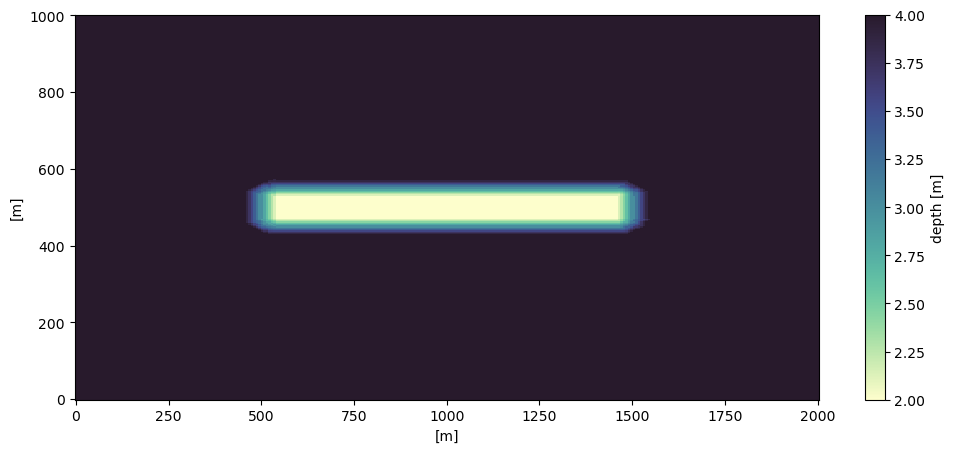

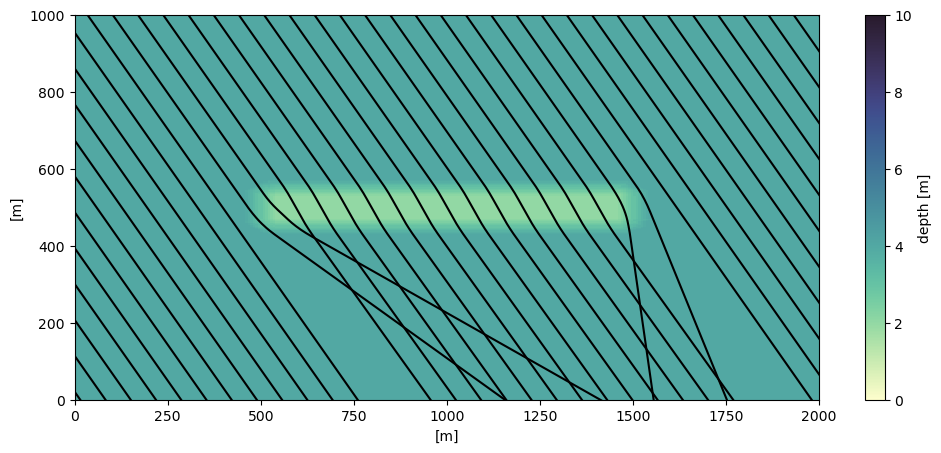

In [10]:
nx = 300; ny = 300 # number of grid points in x- and y-direction
x = np.linspace(0,2000,nx) # size x-domain [m]
y = np.linspace(0,1000,ny) # size y-domain [m]
T = 300 # simulation time [s]
U=np.zeros((ny,nx))
V=np.zeros((ny,nx))
# U[ny//2:,:]=1

nt=300
rays=60

d_off = 4
d_bw = 2

d = np.ones((ny, nx)) * d_off

# for i in range(ny):
#     d[i, :] -= np.ones(nx) * d_off * (1 - i / (ny - 1))

d[int(ny//2-ny/20):int(ny//2+ny/20), int(nx//2-nx/4):int(nx//2+nx/4)] = np.ones((int(ny/10), int(nx/2))) * d_bw

d = smooth(d, 50, 0.2)

xv, yv = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(12, 5));
pc=ax.pcolormesh(xv,yv,d,shading='auto', cmap=cmocean.cm.deep)
dc=fig.colorbar(pc)
dc.set_label('depth [m]')

plt.xlabel('[m]')
plt.ylabel('[m]')

# Define a wave tracing object
wt = Wave_tracing(U=U,V=V,
                       nx=nx, ny=ny, nt=nt,T=T,
                       dx=x[1]-x[0],dy=y[1]-y[0],
                       nb_wave_rays=rays,
                       domain_X0=x[0], domain_XN=x[-1],
                       domain_Y0=y[0], domain_YN=y[-1],
                       d=d)

# Set initial conditions
wt.set_initial_condition(wave_period=10,
                          theta0=-0.3*np.pi, ipx=np.linspace(-2000, 2000, rays), ipy=np.ones(rays)*1000)

# Solve
wt.solve()

# Plot
fig, ax = plt.subplots(figsize=(12, 5));
# pc=ax.pcolormesh(wt.x,wt.y,wt.U.isel(time=0),shading='auto', cmap='Wistia')
pc=ax.pcolormesh(wt.x,wt.y,wt.d,shading='auto', cmap=cmocean.cm.deep, vmin=0, vmax=10)
dc=fig.colorbar(pc)
dc.set_label('depth [m]')

for ray_id in range(wt.nb_wave_rays):
    ax.plot(wt.ray_x[ray_id,:],wt.ray_y[ray_id,:],'-k')

plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

plt.xlabel('[m]')
plt.ylabel('[m]')

# ax.quiver(x, y, U ,V)
plt.show()

In [4]:
# fig,ax = plt.subplots(figsize=(12,8))

# pc=ax.pcolormesh(wt.x,wt.y,wt.d,shading='auto', cmap=cmocean.cm.deep)

# dc=fig.colorbar(pc)
# dc.set_label('depth [m]')

# ax.set_xlim([x.min(), x.max()])
# ax.set_ylim([y.min(), y.max()])

# ax.set_xlabel('[m]')
# ax.set_ylabel('[m]')

# def update(idt):
#     for ray_id in range(0, wt.nb_wave_rays, 1):
#         ax.plot(wt.ray_x[ray_id,:idt],wt.ray_y[ray_id,:idt],'-r')

# ani = animation.FuncAnimation(fig, update, interval=100, save_count=nt, repeat=True, repeat_delay=10000)

# ani.save("bar.gif")

In [11]:
da = xa.open_dataset('data_waves/depth2.nc')

depth = - da.elevation.values  # might need to tweak this

depth = depth.astype(np.float32)

depth[depth < 0] = 0
depth[depth > 800] = 400

In [12]:
# SET conditions for wave tracing

# Domain
X = (da.lon - da.lon[0]) * 111000 
Y = (da.lat - da.lat[0]) * 111000 
X0, XN = X[0].data, X[-1].data
Y0, YN = Y[0].data, Y[-1].data

# Resolution
nx = len(X)
ny = len(Y)

x = np.linspace(X0,XN,nx) # size x-domain [m]
y = np.linspace(Y0,YN,ny) # size y-domain [m]

uu = np.zeros((ny,nx))
vv = np.zeros((ny,nx))

# Number of rays
nb_wave_rays = 140

# Duration (in seconds)
T = 3600 / 2

# Number of discrete time steps
nt = 90

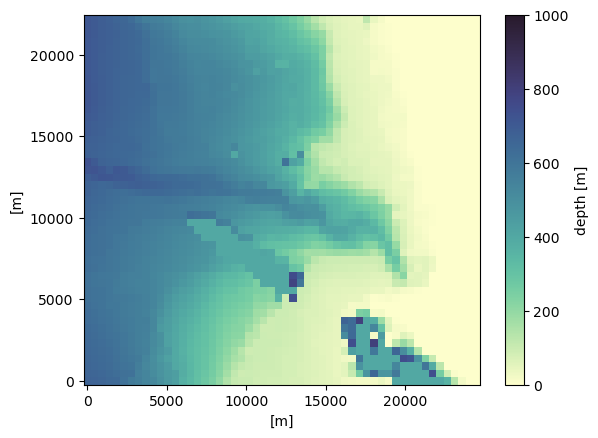

In [13]:
xv, yv = np.meshgrid(x, y)

fig, ax = plt.subplots();
pc=ax.pcolormesh(xv,yv,depth,shading='auto', cmap=cmocean.cm.deep, vmax=1000)
dc=fig.colorbar(pc)
dc.set_label('depth [m]')

plt.xlabel('[m]')
plt.ylabel('[m]');

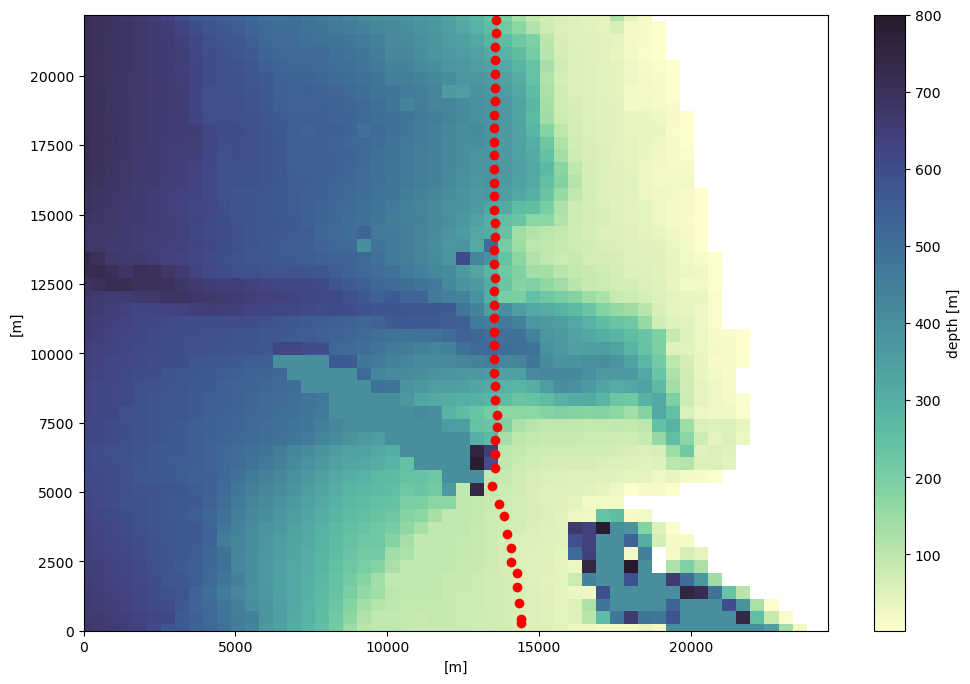

In [17]:
# Define a wave tracing object
wt = Wave_tracing(U=uu, V=vv,
                       nx=nx, ny=ny, nt=nt,T=T,
                       dx=x[1]-x[0],dy=y[1]-y[0],
                       nb_wave_rays=rays,
                       domain_X0=X0, domain_XN=XN,
                       domain_Y0=Y0, domain_YN=YN,
                       d=depth)

# Set initial conditions
wt.set_initial_condition(wave_period=20,
                          theta0=-0.1*np.pi, incomming_wave_side='left', ipx=np.ones(rays)*X0, ipy=np.linspace(Y0, YN + 0.3 * (YN - Y0), rays))



# Solve
wt.solve()

# Plot
fig, ax = plt.subplots(figsize=(12, 8));
pc=ax.pcolormesh(wt.x,wt.y,wt.d,shading='auto', cmap=cmocean.cm.deep)
dc=fig.colorbar(pc)
dc.set_label('depth [m]')

for ray_id in range(wt.nb_wave_rays):
    ax.plot(wt.ray_x[ray_id,45],wt.ray_y[ray_id,45],'or')

plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

plt.xlabel('[m]')
plt.ylabel('[m]')

plt.show()

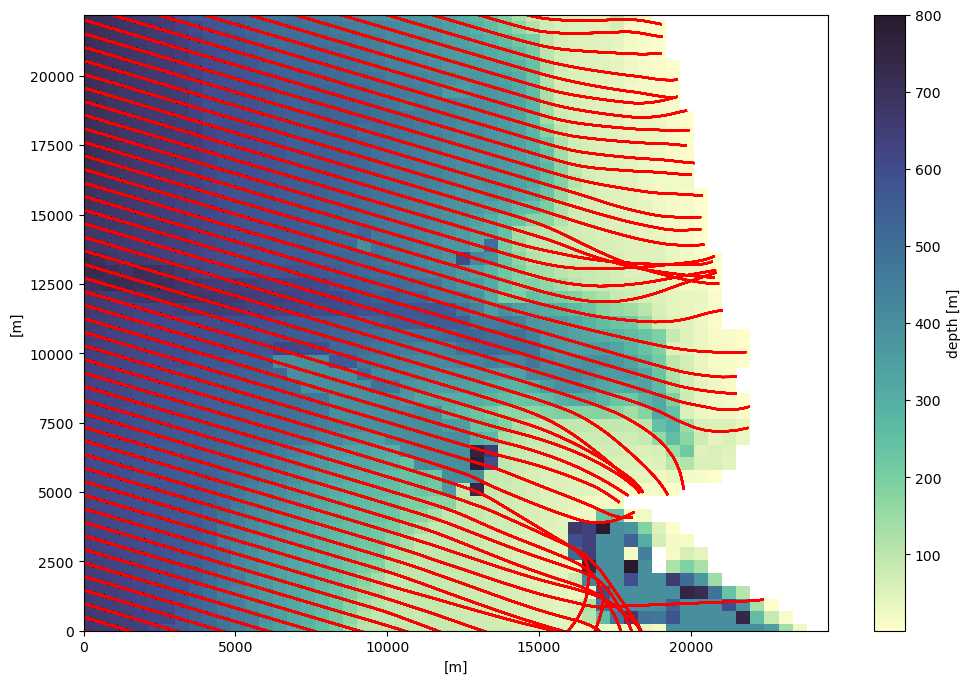

In [15]:
fig,ax = plt.subplots(figsize=(12,8))

pc=ax.pcolormesh(wt.x,wt.y,wt.d,shading='auto', cmap=cmocean.cm.deep)

dc=fig.colorbar(pc)
dc.set_label('depth [m]')

ax.set_xlim([X0,XN])
ax.set_ylim([Y0,YN])

ax.set_xlabel('[m]')
ax.set_ylabel('[m]')

def update(idt):
    for ray_id in range(0, wt.nb_wave_rays, 1):
        ax.plot(wt.ray_x[ray_id,:idt],wt.ray_y[ray_id,:idt],'-r')

ani = animation.FuncAnimation(fig, update, interval=100, save_count=nt, repeat=True, repeat_delay=10000)

ani.save("jolla.gif")